In [1]:
from helpers.utilities import (
    DataFrame, Series, partial,
    T, F, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
from jupyter_helpers.selective_import import notebooks_importer

In [4]:
from analyses.integration.Uniform_preprocessing import (
    # data matrices
    raw_protein_matrix, raw_rna_matrix,
    clinical_union as clinical,
    # misc
    RNA_OUTLIERS,
    patients_union, patients_union_series, patients_with_both,
    # full response vectors derived from clinical data for
    # the union of patients with CSF RNA or with protein data
    protein_conditions,
    # preprocessing
    preprocess,

    # subsets of patients (uniform train-test split)
    full_cm_and_tmdr,        # CM+TMD+TMR patients with CSF RNA or protein data
    intersect_cm_and_tmdr,   # CM+TMD+TMR patients with both CSF RNA and protein data
    cm_and_tmdr_validation,  # CM+TMD+TMR patients with single omic data only
    tms_validation,          # CM patients with single omic data only + all TMS patients
)

Importing Jupyter notebook from /home/krassowski/meningitis-integration/analyses/integration/Uniform_preprocessing.ipynb


In [5]:
from sklearn.pipeline import make_pipeline
from machine_learning.repeated_cv import null_distributions_over_cv, cross_validate_and_test

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [6]:
from plots.cm_vs_tmdr_or_tms import cm_vs_tmdr_or_tms_roc_curves

%R import::here(roc_auc_tmdr_cm, .from='plots/cm_vs_tmdr_or_tms.R')
%R import::here(plot_roc_auc, .from='plots/roc_auc.R')

In [7]:
from machine_learning.multi_block_pipeline import TwoBlockPipeline
from machine_learning.predictions import predict_proba
from machine_learning.preprocessing import ConditionsVectorizer, OutliersFilter

from utilities import subset, add_supervision_block

In [8]:
cross_validate = partial(
    cross_validate_and_test,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

In [9]:
from sklearn.linear_model import LogisticRegressionCV

In [10]:
%%R
import::here(
    coefficients_volcano_plot, plots_most_frequently_included,
    plot_most_significant, plot_highest_magnitutude, mean_vs_coefficients,
    .from='plots/coefficients.R'
)

In [11]:
def create_lasso_pipeline(omic, smallest_group_n, outliers, subset=None, verbose=False, **kwargs):

    return TwoBlockPipeline(
        x=preprocess(omic, smallest_group_n, outliers, verbose=verbose, **kwargs),
        y=make_pipeline(
            OutliersFilter(outlier_patients=outliers, verbose=verbose),
            ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
        ),
        model=LogisticRegressionCV(
            penalty='l1', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

# B) Concatenated omics logistic LASSO

In [12]:
CV_REPEATS_DEMONSTRATIONS = 20
CV_REPEATS_FINAL_MODEL = 100

In [13]:
concatenated = pd.concat([
    raw_rna_matrix.T.add_suffix('.RNA').T,
    raw_protein_matrix.T.add_suffix('.Protein').T
], axis=0)
concatenated.T.head().T

,001.TMD,006.CM,012.BM,016.CM,017.TMD
TSPAN6.RNA,1.0,3.0,2.00,16.00,25.00
TNMD.RNA,0.0,0.0,0.00,1.00,0.00
DPM1.RNA,0.0,12.0,53.00,0.00,73.00
SCYL3.RNA,11.0,56.0,123.84,38.72,124.95
C1orf112.RNA,4.0,0.0,73.16,21.28,15.05
...,...,...,...,...,...
SERPINF1.Protein,193171.3,162506.4,NaN,162015.20,182006.00
CTSF.Protein,1290.1,2159.9,NaN,927.10,652.50
FTCD.Protein,27.3,36.4,NaN,52.40,36.80
USP25.Protein,42.0,72.9,NaN,73.70,67.00


## 1. Using the intersection - shared normalization of blocks

Subsetting is required before normalization in this variant as otherwise we have a lot of NaNs:

In [14]:
concat_intersect = concatenated.loc[:, intersect_cm_and_tmdr]

In [15]:
conditions_intersect = concat_intersect.columns.map(clinical.Meningitis)
conditions_intersect.value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

In [16]:
concatenated_or_zero = concatenated.fillna(0)

In [17]:
%%R -i concatenated_or_zero -i conditions_intersect
colnames(concatenated_or_zero) = remove_leading_X(colnames(concatenated_or_zero))
OMICS_MATRICES[['concatenated']] = concatenated_or_zero
CONDITION_VECTORS[['concatenated']] = conditions_intersect

In [18]:
lasso_pipeline_concat_intersect_shared = create_lasso_pipeline(
    'concatenated',
    smallest_group_n=7,
    subset=intersect_cm_and_tmdr,
    outliers=RNA_OUTLIERS,
    verbose=F,
    omics={'concatenated': concatenated_or_zero}
)

[1] "Retaining: 55.77%"


For increased performance, copy to the R environment once only:

In [19]:
concat_intersect_lasso_shared = cross_validate(
    lasso_pipeline_concat_intersect_shared,
    add_supervision_block(
        {'x': subset(concatenated_or_zero, intersect_cm_and_tmdr, outliers=RNA_OUTLIERS)},
        intersect_cm_and_tmdr
    ),
    test_data=add_supervision_block(
        {'x': subset(concatenated_or_zero, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)},
        cm_and_tmdr_validation
    ),
    n=CV_REPEATS_DEMONSTRATIONS,
    verbose=F,
    stratify=T,
    early_normalization=False
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 6 outliers


In [20]:
roc_auc = concat_intersect_lasso_shared.cross_validation_results.roc_auc

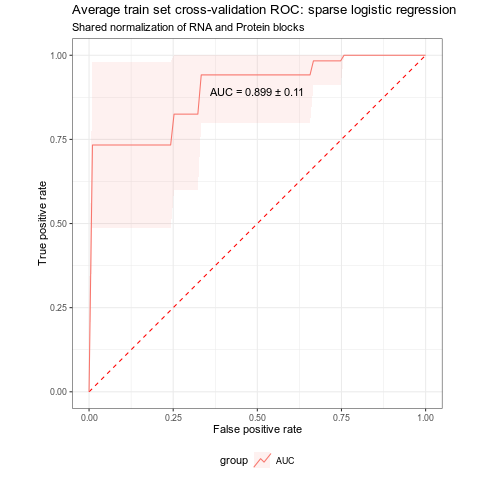

In [21]:
%%R -i roc_auc
(
    plot_roc_auc(roc_auc, mean_auc=T)
    + labs(
        title='Average train set cross-validation ROC: sparse logistic regression',
        subtitle='Shared normalization of RNA and Protein blocks'
    )
)

In [22]:
concat_intersect_lasso_shared.cross_validation.contributions.x.add_weighted_auc(
    concat_intersect_lasso_shared.sub_sampling_test_results.cv_auc
)
concat_intersect_contribs_shared = concat_intersect_lasso_shared.cross_validation.contributions.x.data

28552 genes not selected in any model detected


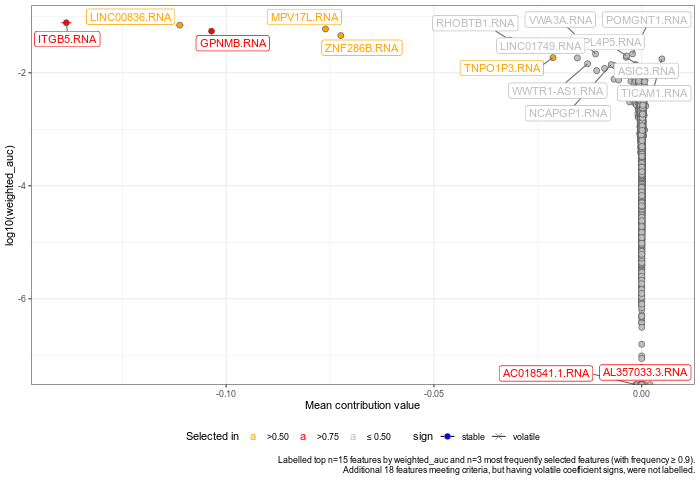

In [60]:
%%R -w 700 -i concat_intersect_contribs_shared

coefficients_volcano_plot(
    concat_intersect_contribs_shared,
    n=15, p_value='weighted_auc', neg=F, point_color='grey40',
    highlight_frequent=0.9
) + ylab('Mean contribution value')

## 2. Using the intersection - separate normalizations

In [24]:
from machine_learning.multi_block_pipeline import MultiBlockPipeline
from machine_learning.data_classes import BlocksWrapper
from machine_learning.combine import BlocksConcatenation
from machine_learning.adapter import SklearnAdapter
from machine_learning.utilities import Suffixer

In [25]:
def create_block_lasso_pipeline(smallest_group_n, outliers, subset=None, verbose=False, **kwargs):
    return MultiBlockPipeline(
        block_pipelines={
            'Protein': make_pipeline(
                preprocess('protein', smallest_group_n, outliers, verbose=verbose, **kwargs),
                Suffixer('.Protein')
            ),
            'RNA': make_pipeline(
                preprocess('rna', smallest_group_n, outliers, verbose=verbose, **kwargs),
                Suffixer('.RNA')
            ),
            'Meningitis': make_pipeline(
                OutliersFilter(outlier_patients=outliers, verbose=verbose),
                ConditionsVectorizer(mapping=clinical.Meningitis, case_class='Tuberculosis')
            )
        },
        combine=BlocksConcatenation(blocks=['Protein', 'RNA']),
        adapter=SklearnAdapter(Combined='X', Meningitis='y'),
        model=LogisticRegressionCV(
            penalty='l1', solver='liblinear',
            class_weight='balanced',
            max_iter=150
        ),
        predict=predict_proba
    )

In [26]:
lasso_pipeline_concat_intersect = create_block_lasso_pipeline(7, outliers=RNA_OUTLIERS)

[1] "Retaining: 99.92%"
[1] "Retaining: 52.62%"


In [27]:
train_data = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, intersect_cm_and_tmdr),
        'RNA': subset(raw_rna_matrix, intersect_cm_and_tmdr, outliers=RNA_OUTLIERS)
    })
    .align_indices()
    .add_supervision_block(intersect_cm_and_tmdr, name='Meningitis')
    .blocks
)

OutliersFilter: filtering out 0 outliers


In [28]:
train_data['Protein'].index.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

In [29]:
train_data['RNA'].index.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

The test data is only available for patients with single omics, not for patients with both omics, as this was the criteria for initial train-test split:

In [30]:
assert not set(cm_and_tmdr_validation).intersection(set(patients_with_both))

If I want to have a test set using these data, it would be degenerate with half of the data (for one or the other omic) missing. The tests could be performed twice, once with RNA missing, once with protein missing as such it would be the best to perform the tests outside of this function which allows for one test only:

In [31]:
concat_intersect_lasso = cross_validate(
    lasso_pipeline_concat_intersect,
    train_data,
    test_data=None,
    n=CV_REPEATS_FINAL_MODEL,
    coefficients={'combined': 'coef_'},
    verbose=T,
    stratify=T,
    early_normalization=False
)

Fitting cross-validation models...



Re-fitting on the entire dataset (no parameters estimated)...


### Test case 1: Use patients with Protein data only (and set missing RNA observations to zero):

In [32]:
test_protein = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        'RNA': subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)
    })
    .nullify_exclusively('RNA')
    .transform_single_block('RNA', Suffixer('.RNA'), mark=True)
    .add_supervision_block(cm_and_tmdr_validation, name='Meningitis')
)

test_protein_dataset = test_protein.to_dataset(
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 3 outliers
OutliersFilter: filtering out 6 outliers


In [33]:
protein_test_result = concat_intersect_lasso.validate(test_protein_dataset)

### Test case 2: Use patients with RNA data only (and set missing Protein observations to zero):

In [34]:
test_rna = (
    BlocksWrapper({
        'Protein': subset(raw_protein_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS),
        'RNA': subset(raw_rna_matrix, cm_and_tmdr_validation, outliers=RNA_OUTLIERS)
    })
    .nullify_exclusively('Protein')
    .transform_single_block('Protein', Suffixer('.Protein'), mark=True)
    .add_supervision_block(cm_and_tmdr_validation, name='Meningitis')
)

test_rna_dataset = test_rna.to_dataset(
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 3 outliers
OutliersFilter: filtering out 6 outliers


In [35]:
rna_test_result = concat_intersect_lasso.validate(test_rna_dataset)

In [36]:
rna_test_result_sub = concat_intersect_lasso.cross_validation.validate(test_rna_dataset)
protein_test_result_sub = concat_intersect_lasso.cross_validation.validate(test_protein_dataset)

In [37]:
roc_auc_concat = pd.concat([
    concat_intersect_lasso.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    protein_test_result_sub.roc_auc.assign(group='Protein CV test: TMD vs CM', models='Cross-Validation', set='Train: Protein, TMD+TMR vs CM'),
    rna_test_result_sub.roc_auc.assign(group='RNA CV test: TMD vs CM', models='Cross-Validation', set='Train: RNA, TMD+TMR vs CM'),
    protein_test_result.roc_auc.assign(group='Protein full test: TMD vs CM', models='Full model', set='Test: Protein, TMD+TMR vs CM'),
    rna_test_result.roc_auc.assign(group='RNA full test: TMD vs CM', models='Full model', set='Test: RNA, TMD+TMR vs CM')
])

 vs 0.9666666666666668


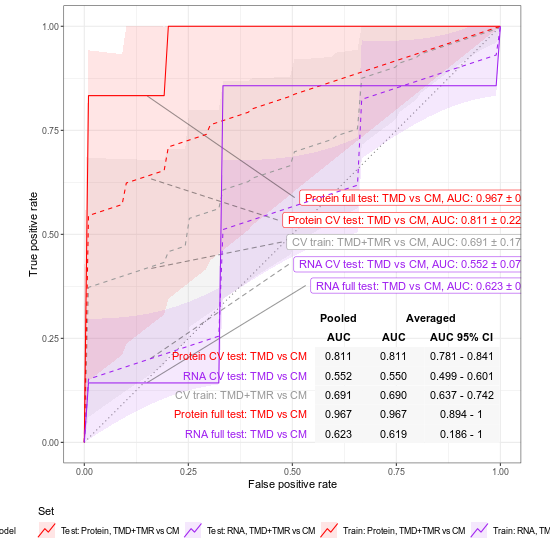

In [38]:
%%R -i roc_auc_concat -w 550 -h 550

colors = c(
    'Train: TMD+TMR vs CM'='#999999',
    'Test: Protein, TMD+TMR vs CM'='red',
    'Test: RNA, TMD+TMR vs CM'='purple',
    'Train: Protein, TMD+TMR vs CM'='red',
    'Train: RNA, TMD+TMR vs CM'='purple'
)

roc_auc_tmdr_cm(roc_auc_concat, annotation=0.15, colors=colors)

In [39]:
len(test_rna.blocks['RNA']), len(test_protein.blocks['Protein'])

(10, 16)

### Features driving models with high AUC

100 models were trained with two omics at once but tested on data from patients having a single omic only (either RNA or Protein). The performance of each model in both scenarios (testing with RNA or with Protein only) was averaged:

In [40]:
average_auc = (Series(protein_test_result_sub.cv_auc) + Series(rna_test_result_sub.cv_auc)) / 2
average_auc.head(3)

0    0.776190
1    0.792857
2    0.752381
dtype: float64

and the features included in the successful models (having high AUC) were visualized, weighting by the contribution strength:

In [41]:
concat_intersect_lasso.cross_validation.contributions.combined.add_weighted_auc(average_auc)
concat_intersect_lasso_contribs = concat_intersect_lasso.cross_validation.contributions.combined.data

33 null models detected
28649 genes not selected in any model detected


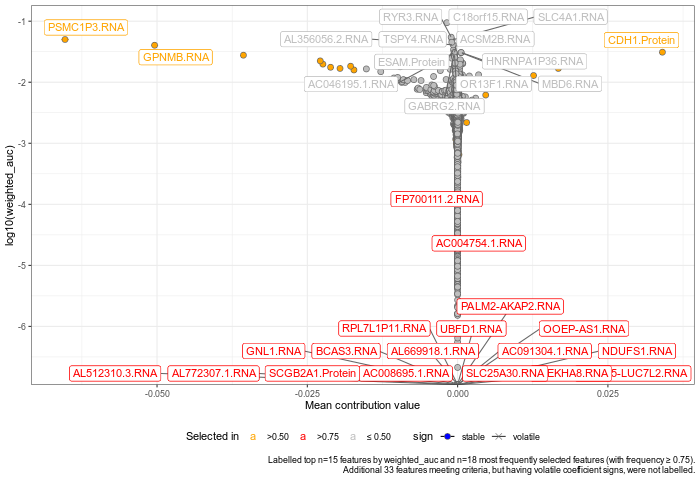

In [42]:
%%R -w 700 -i concat_intersect_lasso_contribs
coefficients_volcano_plot(
    concat_intersect_lasso_contribs,
    n=15, p_value='weighted_auc', neg=F, point_color='grey40',
    highlight_frequent=0.75
) + ylab('Mean contribution value')

On the bottom there are gene products frequently selected by the "bad" models. On the top there are gene products frequently selected in the "good" models and the gene products being the best contributors of the "good models" even if selected rarely.

This visualization is difficult to interpret given that the validation was performed on one omic at a time, thus we cannot read to much out of that. There might be interactions between VAPB, NCBP3 and some proteins which are only improving the classification results (and therefore AUC) if both omics are provided.

On the other hand, in the near future the clinical biomarker panels are more likely to be composed of one omic only, thus the positive results are still interesting.

The top results - proteins: MMP10, <s>TNFSF15</s>, CDH1 and transcript of GPNMB are consistent with previous analyses.

<s>AKT1 and MBD3L2 seem to be novel findings.</s>

PSMC1P3 - HIV1 related?

The gene products which contribute highly to good models but are rarely selected are likely not significant, and while some look nice (IL17RA) we should not cherry-pick. Instead those could be tested for significance with a permutation test.

#### Using internal CV?

One idea would be to look at the AUC of internal CV. This may highlight some Protein-RNA selection preferences:

In [43]:
concat_intersect_lasso.cross_validation.contributions.combined.add_weighted_auc(
    concat_intersect_lasso.cross_validation_results.cv_auc
)
concat_intersect_lasso_cv = concat_intersect_lasso.cross_validation.contributions.combined.data

33 null models detected
28649 genes not selected in any model detected


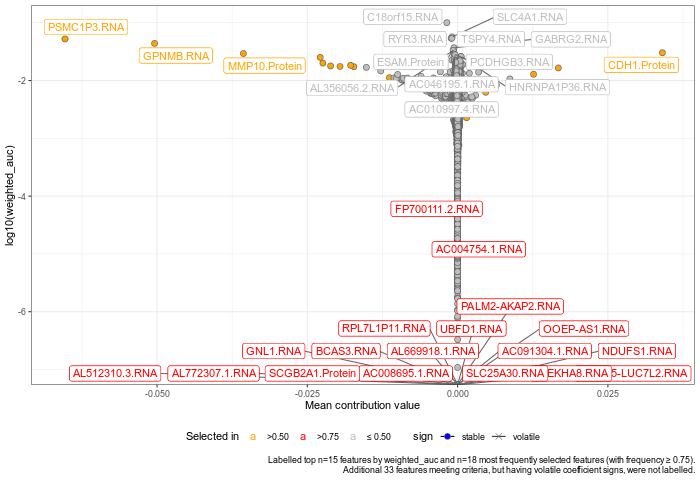

In [44]:
%%R -w 700 -i concat_intersect_lasso_cv
coefficients_volcano_plot(
    concat_intersect_lasso_cv,
    n=15, p_value='weighted_auc', neg=F, point_color='grey40',
    highlight_frequent=0.75
) + ylab('Mean contribution value')

TODO:
 - ROC/AUC - forward-regression for the top 4.
 - PLOS computional biology (look up the recent papers) < 8k definite

This is kind of reassuring to see that the gene products prioritetized by the average model performance on single omics are comparable to those performing well in the internal CV.

In [45]:
auc_comparison = DataFrame(dict(
    average_of_single_omics=average_auc,
    internal_cv=concat_intersect_lasso.cross_validation_results.cv_auc
))

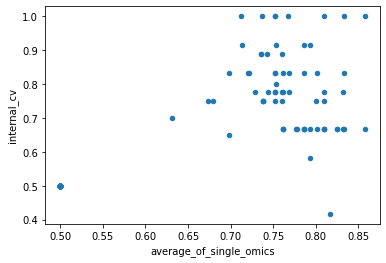

In [46]:
auc_comparison.plot.scatter(x='average_of_single_omics', y='internal_cv');

In [47]:
from scipy.stats import spearmanr

In [48]:
spearmanr(auc_comparison.average_of_single_omics, auc_comparison.internal_cv)

SpearmanrResult(correlation=0.5759451740417546, pvalue=3.6280661925417493e-10)

Maybe we should correct for the internal CV performance? or maybe not..

## 3. With a new test-set set aside ("small model")

So this was fun, but I got nothing to evaluate on except for half empty test dataset (with either RNA of Protein data missing). Instead, I can set some CM aside and use TMS patients with data for both omics; this is not exactly what was done for O2-PLS, however is still interesting to see if we get the same trend (TMS-CM performing better).

In [49]:
train_data['Protein'].index.map(clinical.Meningitis).value_counts()

Cryptococcal    14
Tuberculosis    11
dtype: int64

First off, no need to worry about outliers:

In [50]:
patients_with_both[patients_with_both.isin(RNA_OUTLIERS)]

Series([], Name: 0, dtype: object)

I take all 4 TMS patients for whom there are both omics, which gives 11:4 balance for TBM:

In [51]:
tms_with_both = patients_with_both[patients_with_both.str.endswith('TMS')]
len(tms_with_both)

4

I take random 5 CM from what previously was the test set; this way, I have 10:4 balance for CM:

In [52]:
cm_with_both_test = patients_with_both[patients_with_both.str.endswith('CM')].sample(4, random_state=0)
len(cm_with_both_test)

4

In [53]:
test_for_small_model = pd.concat([tms_with_both, cm_with_both_test])
test_for_small_model.map(clinical.Meningitis).value_counts()

Cryptococcal    4
Tuberculosis    4
Name: 0, dtype: int64

And I construct train set without those excluded for the test set:

In [54]:
train_patients_small = Series(list(
    set(patients_with_both[patients_with_both.str.contains('TM|CM')])
    .difference(test_for_small_model)
))
train_patients_small.map(clinical.Meningitis).value_counts()

Tuberculosis    11
Cryptococcal    10
dtype: int64

In [55]:
small_lasso_concat = cross_validate(
    lasso_pipeline_concat_intersect,
    train_data=(
        BlocksWrapper({
            'Protein': subset(raw_protein_matrix, train_patients_small, outliers=RNA_OUTLIERS),
            'RNA': subset(raw_rna_matrix, train_patients_small, outliers=RNA_OUTLIERS)
        })
        .align_indices()
        .add_supervision_block(train_patients_small, name='Meningitis')
        .blocks
    ),
    test_data=(
        BlocksWrapper({
            'Protein': subset(raw_protein_matrix, test_for_small_model, outliers=RNA_OUTLIERS),
            'RNA': subset(raw_rna_matrix, test_for_small_model, outliers=RNA_OUTLIERS)
        })
        .align_indices()
        .add_supervision_block(test_for_small_model, name='Meningitis')
        .blocks
    ),
    n=CV_REPEATS_DEMONSTRATIONS,
    coefficients={'combined': 'coef_'},
    verbose=False,
    stratify=T,
    early_normalization=False
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers


In [56]:
roc_auc_concat_small = pd.concat([
    small_lasso_concat.cross_validation_results.roc_auc.assign(group='CV train: TMD+TMR vs CM', models='Cross-Validation', set='Train: TMD+TMR vs CM'),
    small_lasso_concat.sub_sampling_test_results.roc_auc.assign(group='CV test: TMS vs CM', models='Cross-Validation', set='Test: TMS vs CM'),
    small_lasso_concat.test_result.roc_auc.assign(group='Full test: TMS vs CM', models='Full model', set='Test: TMS vs CM')
])

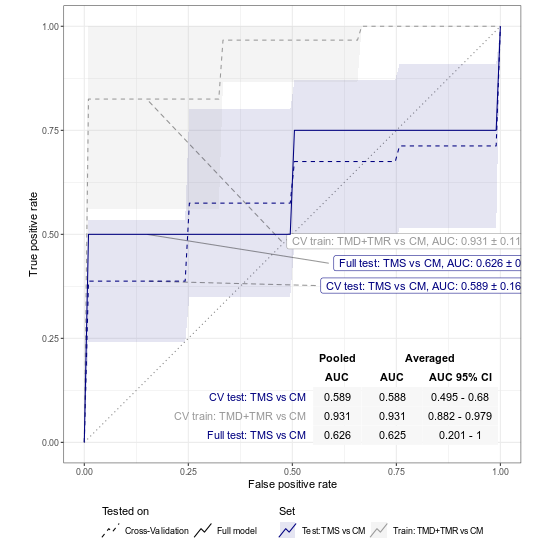

In [57]:
%%R -i roc_auc_concat_small -w 550 -h 550

colors = c(
    'Train: TMD+TMR vs CM'='#999999',
    'Test: TMS vs CM'='navy'
)

roc_auc_tmdr_cm(roc_auc_concat_small, annotation=0.15, colors=colors)

This time, there is no need to average anything as we got proper test results avilable for all the models:

In [58]:
small_lasso_concat.cross_validation.contributions.combined.add_weighted_auc(
    small_lasso_concat.sub_sampling_test_results.cv_auc
)
small_lasso_contribs = small_lasso_concat.cross_validation.contributions.combined.data

31045 genes not selected in any model detected


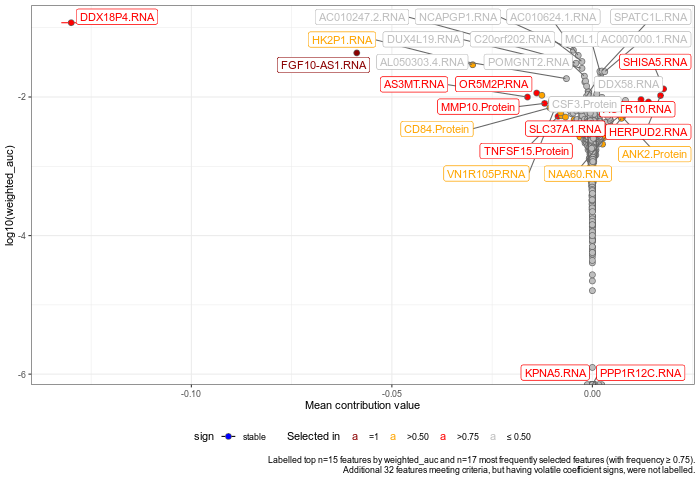

In [59]:
%%R -w 700 -i small_lasso_contribs
coefficients_volcano_plot(
    small_lasso_contribs,
    n=15, p_value='weighted_auc', neg=F, point_color='grey40',
    highlight_frequent=0.75
) + ylab('Mean contribution value')

# TODO: what happened to TNFSF15?